In [1]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex5 import *

# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_lags, make_lags, make_leads

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

In [3]:
import numpy as np
import pandas as pd
from helper.Loader import Loader
import matplotlib.pyplot as plt
import seaborn as sns
from helper.get_data import pivot_table_all
database = 'market_research'
table_name = 'ohlc'
start_date = "2012-01-01"
end_date = "2022-01-26"

"""
"""
wind_codes = pd.read_csv('beer.txt',sep=' ', header=None,)
wind_codes = wind_codes[0].to_list()
field = "symbol,date,close"
# options = "PriceAdj=DP"
loader = Loader(start_date, end_date, database, table_name, field, None)
df = loader.fetch_data(database, table_name, wind_codes, field)
df.head()
table = pivot_table_all(df, 'date', 'symbol', 'close').to_period('D')

table = pd.concat({'Close': table}, names=[None, 'symbol'], axis=1)
table

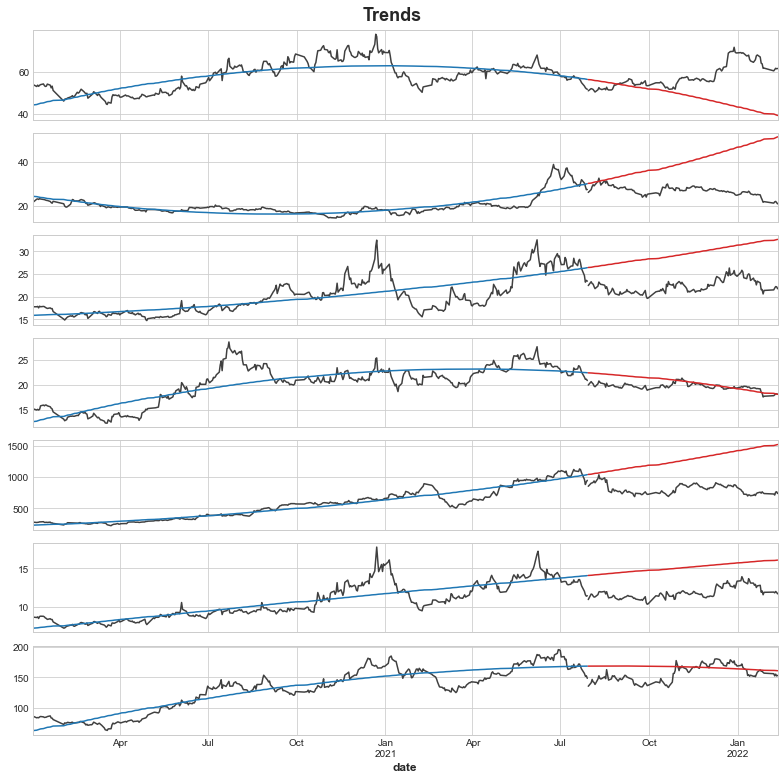

In [5]:
from sklearn.model_selection import train_test_split

y = table["2020-01":].copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=0.25, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True, figsize=(11, 11))
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [6]:
# The `stack` method converts column labels to row labels, pivoting from wide format to long
X = table["2020-01":].stack()  # pivot dataset wide to long
display(X.head())
y = X.pop('Close')  # grab target series  DataFrame.pop(item)[source]
                    # Return item and drop from frame. Raise KeyError if not found.

Close
date       symbol             
2020-01-02 000729.SZ   53.7701
           000752.SZ   21.9947
           000929.SZ   17.7616
           002461.SZ   15.0582
           600132.SH  278.9800

In [7]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('symbol')
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["day"] = X.index.dayofyear  # values are 1, 2, ..., 12
X["week"] = X.index.week
X["month"] = X.index.month
# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [8]:
X

,symbol,day,week,month
date,,,,
2020-01-02,0,2,1,1
2020-01-02,1,2,1,1
2020-01-02,2,2,1,1
2020-01-02,3,2,1,1
2020-01-02,4,2,1,1
...,...,...,...,...
2022-02-11,2,42,6,2
2022-02-11,3,42,6,2
2022-02-11,4,42,6,2


In [9]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

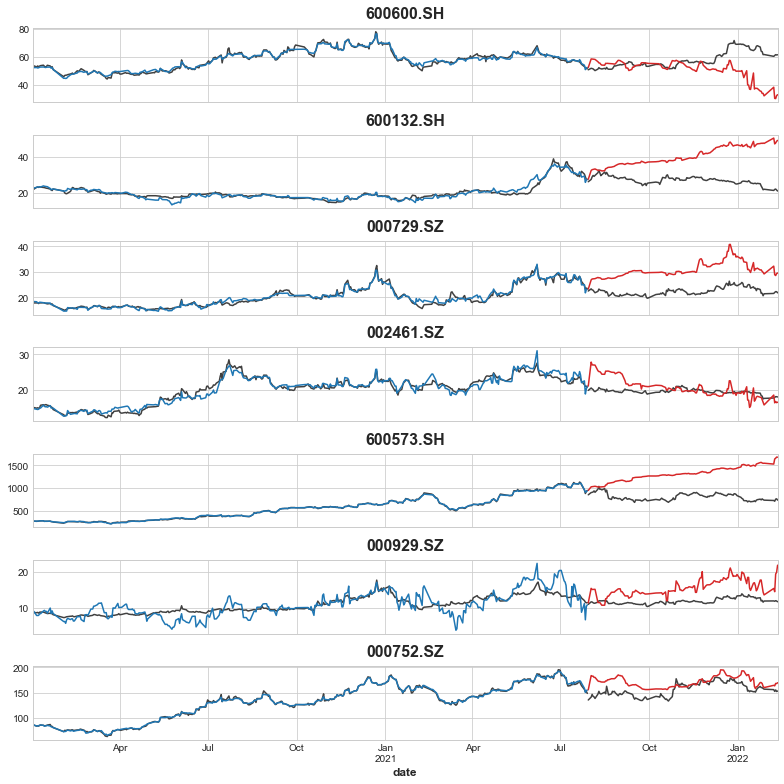

In [10]:
axs = y_train.unstack(['symbol']).plot(
    color='0.25',  subplots=True, sharex=True, figsize=(11, 11),
    title=wind_codes
)
axs = y_test.unstack(['symbol']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['symbol']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['symbol']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

In [11]:
def holiday2businessday(datelist):
    import QuantLib as ql
    datelist1 = []
    cal = ql.China()
    for date in datelist:
        mydate = ql.Date(date.days_in_month, date.month, date.year)
        while cal.isHoliday(mydate):
            mydate = mydate + ql.Period(1, ql.Days)
        datelist1.append(mydate.ISO())
        # print('Is Holiday :', cal.isHoliday(mydate))
        # print(mydate)
    # print(datelist)
    # print(ax1.index)
    return pd.PeriodIndex(datelist1, freq='D')

# database = 'market_research'
table_name = 'finance_rpt'
field_growth =  "date,symbol,yoyeps_basic,yoyeps_diluted,yoyocfps,yoy_tr,yoy_or,yoyop,yoyop2,yoyebt,yoyprofit,yoynetprofit,yoynetprofit_deducted,dp_yoy,yoyroe,yoyocf,maintenance,yoy_cash,yoy_fixedassets,fa_rdexp_yoy,yoy_equity,yoycf,yoydebt,yoy_assets"
field_profit = "roe_avg,roe_basic,roe_diluted,roe_deducted,roe_exbasic,roe_exdiluted,roe_add,roa2,roa,roic,ROP,roe_yearly,roa2_yearly,roa_yearly,netprofitmargin,netprofitmargin_deducted,grossprofitmargin,cogstosales,nptocostexpense,expensetosales,optoebt,profittogr,optogr,ebittogr,gctogr,operateexpensetogr,adminexpensetogr,finaexpensetogr,impairtoOP,ebitdatosales"
field = field_growth + "," + field_profit
loader = Loader(start_date, end_date, database, table_name, field, None)
df = loader.fetch_data(database, table_name, wind_codes, field)
# display(df)
df['date'] = df.date.dt.to_period('D')
df = df.set_index(['date', 'symbol']).sort_index()

table2 = (
    df
    .groupby(['date', 'symbol'])
    .mean()
    .unstack('symbol')
    .loc['2019':]
)
# display(table2)

table2.index = holiday2businessday(table2.index)

# table_ = pd.concat([
#     table.loc['2020':],
#     table2
# ], 
#     axis=1)
# display(table_.fillna(0.0))

# display(table2)
df1 = table.loc['2019-12':]
df2 = table2
a1, a2 = df1.align(df2, join='left', axis=0, method = 'ffill', fill_axis = 0)
# a1, a2 = df1.align(df2, join='left', axis=0, fill_value = 0.0 )
# print(a1)
# print(a2['2020-1':])

table1_ = pd.concat([
    table.loc['2020'],
    a2['2020']
], 
    axis=1)
display(table1_)    

Data found!


Close                                                             yoyeps_basic                          ... impairtoOP                      ebitdatosales                                                                  
symbol     000729.SZ 000752.SZ 000929.SZ 002461.SZ 600132.SH 600573.SH 600600.SH    000729.SZ   000752.SZ   000929.SZ  ...  600132.SH  600573.SH 600600.SH     000729.SZ  000752.SZ  000929.SZ  002461.SZ  600132.SH  600573.SH  600600.SH
date                                                                                                                   ...                                                                                                                
2020-01-02   53.7701   21.9947   17.7616   15.0582   278.980    8.7682   85.6109    28.125000   20.253165  123.157316  ...  -3.355775  -6.908622 -4.486893     10.606288 -68.337023   3.634063  15.157757  28.017807  10.179147  12.018880
2020-01-03   53.6083   21.9470   17.7866   15.1414   277.308    8.6896   85.8454    28.125000   20.253165  123.157316  ...  -3.355775  -6.908622 -4.486893     10.606288 -68.337023   3.634063  15.157757  28.017807  10.179147  12.018880
2020-01-06   52.8806   23.0443   17.7866   14.9542   272.722    8.6503   83.7684    28.125000   20.253165  123.157316  ...  -3.355775  -6.908622 -4.486893     10.606288 -68.337023   3.634063  15.157757  28.017807  10.179147  12.018880
2020-01-07   53.5275   23.1875   17.8615   15.0790   274.179    8.7289   84.2542    28.125000   20.253165  123.157316  ...  -3.355775  -6.908622 -4.486893     10.606288 -68.337023   3.634063  15.157757  28.017807  10.179147  12.018880
2020-01-08   52.9615   22.9489   17.5368   14.9542   276.930    8.5192   83.7852    28.125000   20.253165  123.157316  ...  -3.355775  -6.908622 -4.486893     10.606288 -68.337023   3.634063  15.157757  28.017807  10.179147  12.018880
...              ...       ...       ...       ...       ...       ...       ...          ...         ...         ...  ...        ...        ...       ...           ...        ...        ...        ...        ...        ...        ...
2020-12-25   68.9154   18.1778   26.3052   22.4319   630.228   14.5820  165.4050   -24.669604   -6.644035 -221.428571  ...  -1.485355  -6.908622 -0.211008     14.381722   7.860564  -9.109071  17.591434  25.911794   8.040220  18.279232
2020-12-28   70.4559   18.3210   27.3294   23.1053   636.907   15.5164  165.5730   -24.669604   -6.644035 -221.428571  ...  -1.485355  -6.908622 -0.211008     14.381722   7.860564  -9.109071  17.591434  25.911794   8.040220  18.279232
2020-12-29   68.2668   18.2255   25.0811   22.4950   636.686   14.6084  167.2950   -24.669604   -6.644035 -221.428571  ...  -1.485355  -6.908622 -0.211008     14.381722   7.860564  -9.109071  17.591434  25.911794   8.040220  18.279232
2020-12-30   69.7262   18.0824   26.0553   22.9159   647.779   15.5954  168.2060   -24.669604   -6.644035 -221.428571  ...  -1.485355  -6.908622 -0.211008     14.381722   7.860564  -9.109071  17.591434  25.911794   8.040220  18.279232
2020-12-31   69.0776   18.2255   25.8805   22.4950   656.720   15.3848  167.7680   -14.634146  103.968254 -291.092637  ...  -3.556919 -11.731115 -4.016932     10.850273  21.854109 -17.947720  18.304154  23.177161   9.055980  14.019865

[243 rows x 371 columns]

In [12]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

    def fit(self, X_1, X_2, y):
        # Train model_1
        self.model_1.fit(X_1, y)

        # Make predictions
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index, columns=y.columns,
        )

        # Compute residuals
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze() # wide to long

        # Train model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid

    def predict(self, X_1, X_2):
        # Predict with model_1
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long

        # Add model_2 predictions to model_1 predictions
        y_pred += self.model_2.predict(X_2)

        return y_pred.unstack()

In [13]:
# Target series
y = table1_.loc[:, 'Close']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = table1_.drop('Close', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('symbol')
X_2['symbol'] = le.fit_transform(X_2['symbol'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

# X_1, X_2, y

In [18]:
# YOUR CODE HERE: Create LinearRegression + XGBRegressor hybrid with BoostedHybrid
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)

# YOUR CODE HERE: Fit and predict
model.fit(X_1, X_2, y)
y_pred = model.predict(X_1, X_2)

y_pred = y_pred.clip(0.0)

In [15]:
# Model 1 (trend)
from pyearth import Earth
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid

# YOUR CODE HERE: Try different combinations of the algorithms above
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

In [19]:
from sklearn.model_selection import train_test_split

X1_train, X1_valid, y_train, y_valid = train_test_split(X_1,  y, test_size=30, shuffle=False)
idx_train = X1_train.index[-1]
idx_valid = X1_valid.index[0]
X2_train, X2_valid = X_2.loc[:idx_train], X_2.loc[idx_valid:]

# print(X1_train.index[-1])
# print(X1_valid.index[0])
# print(y_train.index[-1])
# print(y_valid.index[0])
# print(X2_train.index[-1])
# print(X2_valid.index[0])

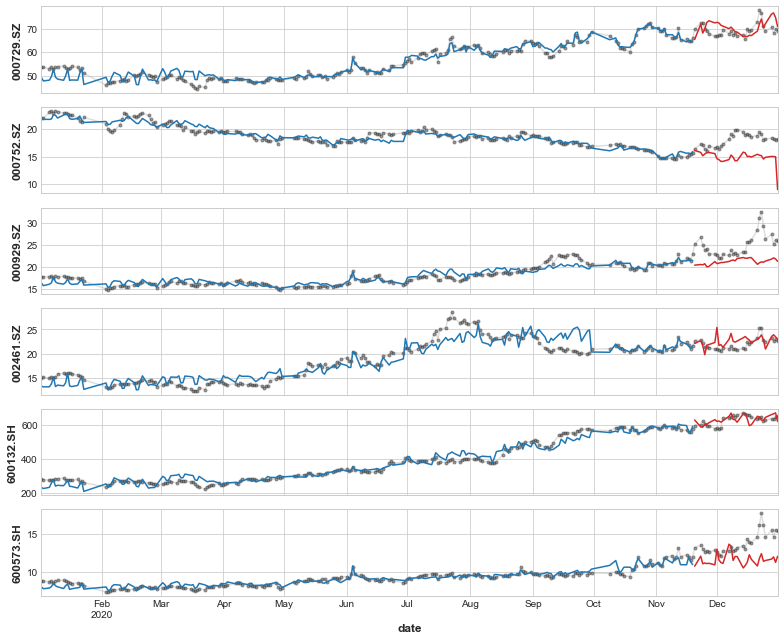

In [20]:
# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)